In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.layers import Conv2D, Activation, Input, Flatten, Dense, LeakyReLU
from os.path import join
from deepsky.gan import unscale_multivariate_data, rescale_data
import keras.backend as K
from deepsky.kriging import random_field_generator
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"


In [2]:
gan_path = "/scratch/dgagne/random_gan_20170905/"
gan_params = pd.read_csv(join(gan_path, "gan_param_combos.csv"), index_col="Index")

In [4]:
gan_params.loc[776]

activation                 leaky
batch_size                   256
beta_one                     0.5
data_width                    32
dropout_alpha               0.05
filter_width                   3
generator_input_size          32
learning_rate             0.0001
length_scale              full;3
min_conv_filters             128
min_data_width                 4
output_activation         linear
seed                    14268489
train_size                131072
Name: 776, dtype: object

In [6]:
gan_params.loc[gan_params["length_scale"] == "full;3"]

(162, 14)

In [11]:
gan_index = 776
epoch = 10
gan_gen = load_model(join(gan_path, "gan_generator_{0:04d}_epoch_{1:04d}.h5".format(gan_index, epoch)))
gan_enc = load_model(join(gan_path, "gan_encoder_{0:04d}_epoch_{1:04d}.h5".format(gan_index, epoch)))

scaling_values = pd.read_csv(join(gan_path, "scaling_values_{0:04d}.csv".format(gan_index)))

In [12]:
scaling_values

,Channel,mean,std
0,0,-0.000341,0.999781


In [12]:
gan_diag_preds = gan_gen.predict(0 * np.identity(16))

In [21]:
x = np.arange(32)
y = np.arange(32)
x_g, y_g = np.meshgrid(x, y)
field_gen = random_field_generator(x_g, y_g, [3])
test_fields = np.array([next(field_gen) for x in range(100)])

In [20]:
gan_sub_params = gan_params.loc[gan_params["length_scale"] == "full;3"]
sample_scores = pd.DataFrame(index=gan_sub_params.index, columns=["ME", "RMSE", "MAE"])
epoch = 10
for g_index in gan_sub_params.index:
    gan_gen = load_model(join(gan_path, "gan_generator_{0:04d}_epoch_{1:04d}.h5".format(g_index, epoch)))
    gan_enc = load_model(join(gan_path, "gan_encoder_{0:04d}_epoch_{1:04d}.h5".format(g_index, epoch)))
    gan_recreations = gan_gen.predict(gan_enc.predict(test_fields))
    diffs = gan_recreations - test_fields
    sample_scores.loc[g_index, "ME"] = np.mean(diffs)
    sample_scores.loc[g_index, "RMSE"] = np.sqrt(np.mean(diffs ** 2))
    sample_scores.loc[g_index, "MAE"] = np.mean(np.abs(diffs))
    print(g_index)
    print(sample_scores.loc[g_index])
    del diffs
    del gan_gen
    del gan_enc
    del gan_recreations

0
ME      0.0244134
RMSE      1.06618
MAE      0.844011
Name: 0, dtype: object
1
ME      2.05737
RMSE    5.69932
MAE     4.60759
Name: 1, dtype: object
2
ME      0.236893
RMSE     1.10796
MAE     0.881524
Name: 2, dtype: object
18
ME     -0.115291
RMSE     1.01985
MAE     0.809694
Name: 18, dtype: object
19
ME      0.0320042
RMSE      1.02551
MAE      0.815337
Name: 19, dtype: object
20
ME     -0.0160523
RMSE        1.108
MAE      0.882604
Name: 20, dtype: object
36
ME     -0.0111029
RMSE     0.996353
MAE      0.790754
Name: 36, dtype: object
37
ME     -0.0278134
RMSE      1.12244
MAE      0.881908
Name: 37, dtype: object
38
ME     -0.0836617
RMSE       1.0193
MAE      0.812937
Name: 38, dtype: object
54
ME     -0.0756576
RMSE      1.08307
MAE      0.862273
Name: 54, dtype: object
55
ME      0.113323
RMSE     1.11341
MAE     0.887696
Name: 55, dtype: object
56
ME     -0.296707
RMSE     1.20895
MAE     0.961219
Name: 56, dtype: object
72
ME     -0.0511035
RMSE      1.04156
MAE      0.82

ResourceExhaustedError: OOM when allocating tensor with shape[12800,128]
	 [[Node: Variable_226/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_226"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_226, Const_682)]]

Caused by op 'Variable_226/Assign', defined at:
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-4683d2293f68>", line 6, in <module>
    gan_enc = load_model(join(gan_path, "gan_encoder_{0:04d}_epoch_{1:04d}.h5".format(g_index, epoch)))
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/models.py", line 272, in load_model
    model._make_train_function()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/engine/training.py", line 937, in _make_train_function
    self.total_loss)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/optimizers.py", line 415, in get_updates
    ms = [K.zeros(K.get_variable_shape(p), dtype=K.dtype(p)) for p in params]
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/optimizers.py", line 415, in <listcomp>
    ms = [K.zeros(K.get_variable_shape(p), dtype=K.dtype(p)) for p in params]
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/backend/tensorflow_backend.py", line 603, in zeros
    dtype, name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/backend/tensorflow_backend.py", line 321, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 306, in _init_from_args
    validate_shape=validate_shape).op
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/ops/state_ops.py", line 270, in assign
    validate_shape=validate_shape)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[12800,128]
	 [[Node: Variable_226/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_226"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_226, Const_682)]]


In [41]:
gan_gen.layers

In [47]:
layer = gan_gen.layers[8]
get_activations = K.function([gan_gen.layers[0].input, K.learning_phase()], [layer.output,])
activations = get_activations([2 * np.identity(16), 0])[0]

In [36]:
def make_act_quilt(activations, ex):
    row = 0
    col = 0
    dim = int(np.sqrt(np.prod(activations.shape[1:])))
    width = activations.shape[1]
    act_quilt = np.zeros((dim, dim))
    for i in range(activations.shape[-1]):
        act_quilt[row:row+width, col:col+width] = activations[ex, :, :, i]
        if row < dim - width:
            row += width
        else:
            row = 0
            col += width
    return act_quilt
                  


In [32]:
act_quilt

array([[-0.03492292, -0.01734546, -0.01591329, ..., -0.0168224 ,
        -0.01606885, -0.0094415 ],
       [-0.00709019, -0.00990508, -0.01510969, ..., -0.01003858,
        -0.00277421, -0.01548788],
       [-0.00814182, -0.01293612, -0.00496435, ..., -0.00516959,
        -0.00715745, -0.01283018],
       ..., 
       [-0.00573373, -0.01342765, -0.01075676, ...,  0.0124332 ,
        -0.00300382, -0.0122514 ],
       [-0.01531009, -0.01363903, -0.01338373, ..., -0.01706735,
         0.00151476, -0.00050488],
       [-0.00192325, -0.01298147, -0.00163521, ..., -0.01773006,
        -0.01704599, -0.02076046]])

In [48]:
for i in range(16):
    act_quilt = make_act_quilt(activations, i)
    dim = int(np.sqrt(np.prod(activations.shape[1:])))
    width = activations.shape[1]
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(act_quilt, cmap="RdBu", vmin=-0.5, vmax=0.5)
    plt.xticks(np.arange(0, dim + width, width))
    plt.yticks(np.arange(0, dim + width, width))
    plt.grid()
    plt.title("Second Convolution Layer Activations Input 1 at Position {0:d}".format(i))
    plt.savefig("all_twos/conv_act_layer_2_ex_{0:02d}.png".format(i), dpi=300, bbox_inches="tight")
    plt.close()

In [9]:
dense_weights = gan_gen.layers[1].get_weights()

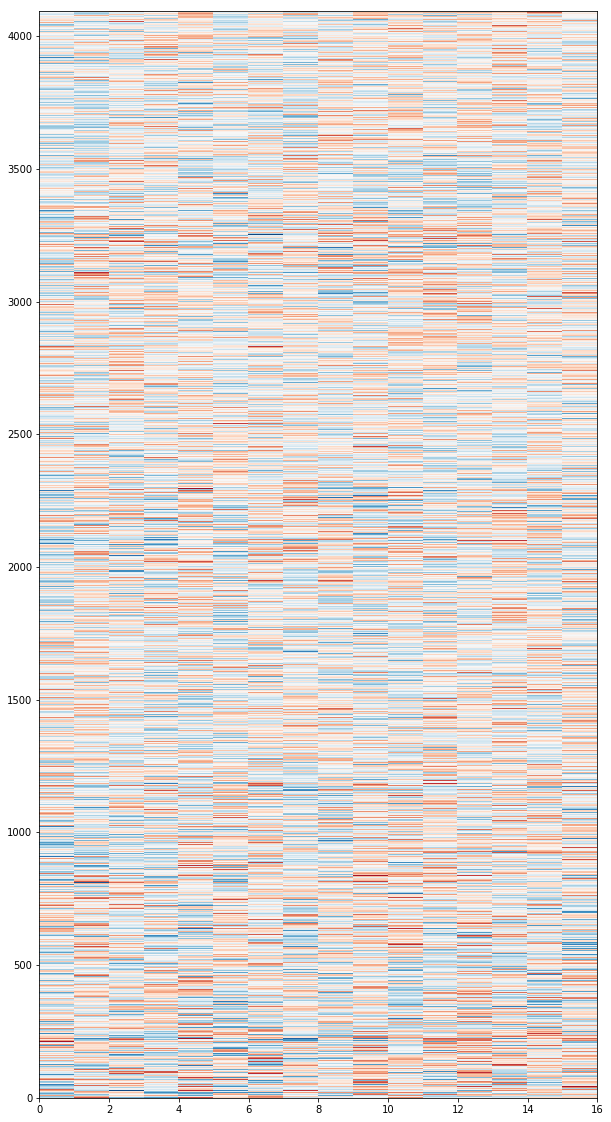

In [76]:
ext = np.max(np.abs(dense_weights[0]))
plt.figure(figsize=(10, 20))
plt.pcolormesh(dense_weights[0].T, vmin=-ext, vmax=ext, cmap="RdBu_r")

In [ ]:
plt.boxplot(dense_weights[0].T)

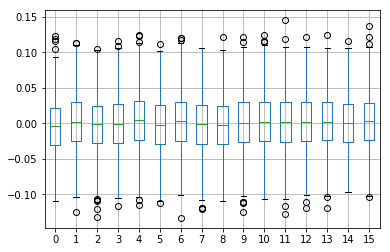

In [11]:
pd.DataFrame(dense_weights[0].T).boxplot()

In [56]:
conv_weights = gan_gen.layers[7].get_weights()[0]
conv_quilt = np.zeros((5 * 128, 5 * 64))
row = 0
col = 0
for fil in range(128):
    for lev in range(64):
        conv_quilt[fil * 5: fil * 5 + 5, lev * 5: lev * 5 + 5] = conv_weights[:, :, lev, fil]

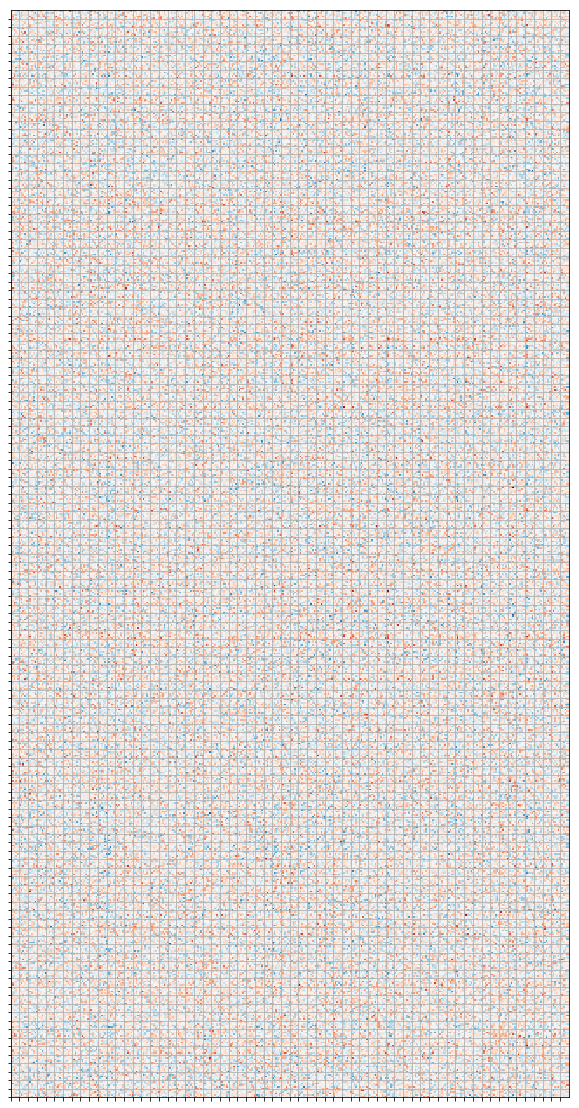

In [76]:
fig, ax = plt.subplots(figsize=(10, 20))
plt.pcolormesh(conv_quilt, vmin=-0.14, vmax=0.14, cmap="RdBu_r")
plt.xticks(np.arange(0, 64 * 5, 5), np.arange(64))
plt.yticks(np.arange(0, 128 * 5, 5), np.arange(128))
plt.grid()
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_xticks([])
#ax.set_yticks([])
plt.savefig("gen_conv_filters_set_2.png", dpi=400, bbox_inches="tight")

In [72]:
conv_quilt.max()

0.13600747287273407

In [84]:
conv_weights_final = gan_gen.layers[10].get_weights()[0]
conv_quilt_final = np.zeros((5 * 8, 5 * 8))
row = 0
col = 0
for fil in range(64):
    conv_quilt_final[row * 5: row * 5 + 5, col * 5: col * 5 + 5] = conv_weights[:, :, 0, fil]
    if row < 7:
        row += 1
    else:
        row = 0
        col += 1

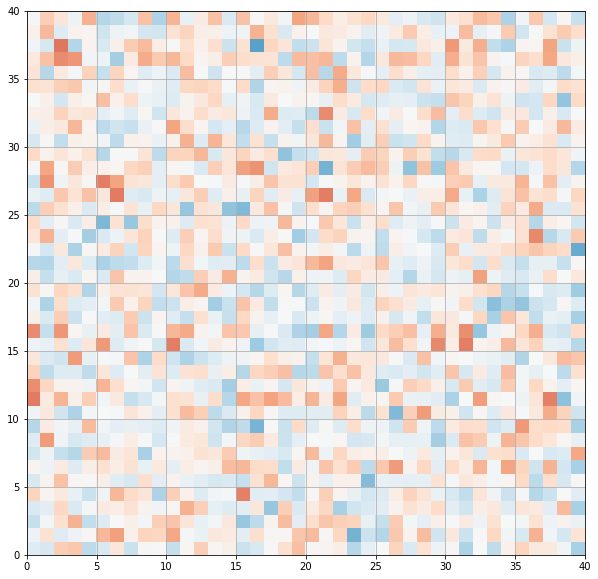

In [88]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(conv_quilt_final, vmin=-0.15, vmax=0.15, cmap="RdBu_r")
plt.grid()

In [47]:
reg_vecs = np.tile(np.linspace(-3, 3, 25), 32).reshape(32, 25).T
reg_vecs

array([[-3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  ,
        -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  ,
        -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  , -3.  ,
        -3.  , -3.  , -3.  , -3.  , -3.  ],
       [-2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75,
        -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75,
        -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75, -2.75,
        -2.75, -2.75, -2.75, -2.75, -2.75],
       [-2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 ,
        -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 ,
        -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 , -2.5 ,
        -2.5 , -2.5 , -2.5 , -2.5 , -2.5 ],
       [-2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
        -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
        -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
        -2.25, -

In [48]:
reg_out = gan_gen.predict(reg_vecs)

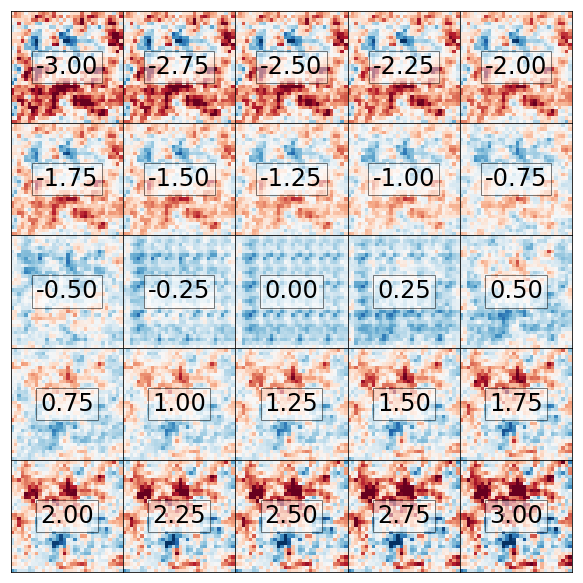

In [49]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
plt.subplots_adjust(0.02, 0.02, 0.8, 0.8, wspace=0, hspace=0)
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.pcolormesh(reg_out[a, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.text(16, 16, "{0:1.2f}".format(reg_vecs[a, 0]), fontsize=24, color="k", ha="center", va="center", bbox=dict(facecolor='w', alpha=0.5))

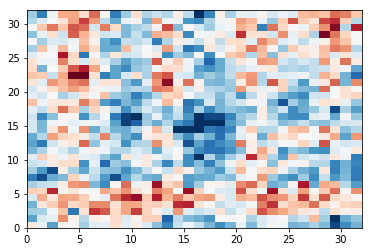

In [29]:
plt.pcolormesh(reg_out[0, :, :, 0] + reg_out[-1, :, :, 0], vmin=-4, vmax=4, cmap="RdBu_r")

In [54]:
enc_out = gan_enc.predict(gan_gen.predict(3 * np.identity(32)))

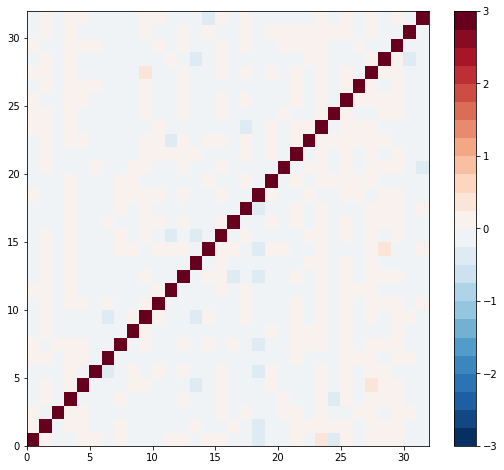

In [56]:
plt.figure(figsize=(9,8))
plt.pcolormesh(enc_out, vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r", 24))
plt.colorbar()

In [57]:
x = np.arange(32)
y = np.arange(32)
x_g, y_g = np.meshgrid(x, y)
field_gen = random_field_generator(x_g, y_g, [3])

In [58]:
out_field = np.stack([next(field_gen) for i in range(2)], axis=0)

In [59]:
gan_out_field = gan_gen.predict(gan_enc.predict(out_field))
gan_out_field_norm = (gan_out_field - gan_out_field.mean()) / gan_out_field.std()

In [62]:
gan_out_field.mean(), gan_out_field.std()

(-0.82298779, 0.70772344)

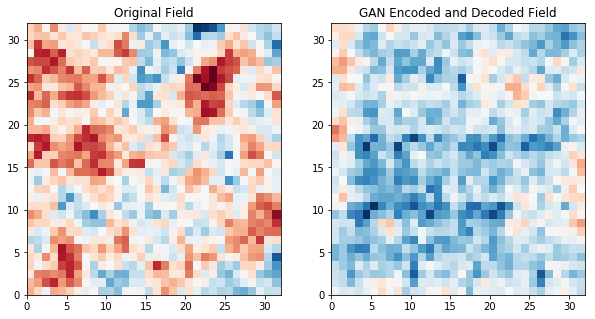

In [63]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Field")
plt.pcolormesh(out_field[0, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")
plt.subplot(1,2,2)
plt.title("GAN Encoded and Decoded Field")
plt.pcolormesh(gan_out_field[0, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

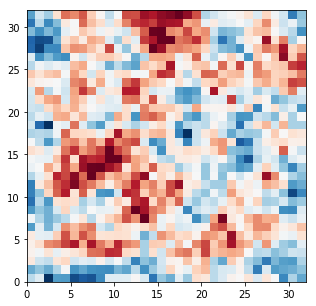

In [170]:
plt.figure(figsize=(5,5))
plt.pcolormesh(gan_out_field[1, :, :, 0] - out_field[1, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")

In [179]:
def encoder_model(input_size=(32, 32, 1), filter_width=5, min_data_width=4,
                    min_conv_filters=64, output_size=100, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="enc_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same")(image_input)
        else:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same")(model)
        model = LeakyReLU(0.2)(model)
        curr_conv_filters *= 2
    model = Flatten()(model)
    model = Dense(int(curr_conv_filters / 2 * filter_width ** 2))(model)
    model = LeakyReLU(0.2)(model)
    model = Dense(output_size)(model)
    model = Activation("linear")(model)
    return model, image_input

In [275]:
enc_ind, enc_ind_input = encoder_model(min_conv_filters=64, output_size=16)

In [183]:
z_set = np.random.normal(size=(100000, 16))
gen_set = gan_gen.predict(z_set)

In [276]:
enc_ind_model = Model(enc_ind_input, enc_ind)
enc_ind_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss="mse")

In [277]:
enc_hist = enc_ind_model.fit(gen_set, z_set, epochs=5, verbose=2)

Epoch 1/5
136s - loss: 0.0115
Epoch 2/5
136s - loss: 0.0019
Epoch 3/5
136s - loss: 0.0014
Epoch 4/5
136s - loss: 0.0012
Epoch 5/5
136s - loss: 0.0010


In [286]:
enc_hist.history

{'loss': [0.011536780834868551,
  0.0018603245214372872,
  0.0014229877404682337,
  0.0011752586500905454,
  0.0010152293824218213]}

In [265]:
enc_ind_preds = enc_ind_model.predict(gan_gen.predict(0.25 * np.identity(16)))

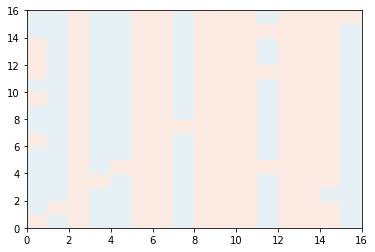

In [266]:
plt.pcolormesh(enc_ind_preds, vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r", 12))

In [67]:
enc_ind_model.predict(scaled_out_field).min()

NameError: name 'enc_ind_model' is not defined

In [66]:
gan_out_field = unscale_multivariate_data(gan_gen.predict(enc_ind_model.predict(scaled_out_field)), scaling_values=scaling_values)

NameError: name 'enc_ind_model' is not defined

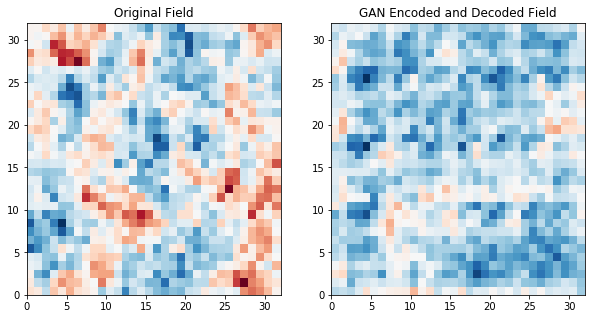

In [65]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Field")
plt.pcolormesh(out_field[1, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")
plt.subplot(1,2,2)
plt.title("GAN Encoded and Decoded Field")
plt.pcolormesh(gan_out_field[1, :, :, 0], vmin=-3, vmax=3, cmap="RdBu_r")